In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the full FAOSTAT crop data
df_yield = pd.read_csv("FAOSTAT_data_en_7-31-2025.csv", encoding='latin-1')

# Filter for Maize (corn) yield
maize_yield = df_yield[
    (df_yield['Item'] == 'Maize (corn)') &
    (df_yield['Element'] == 'Yield')
].copy()

# Keep relevant columns
maize_yield = maize_yield[['Year', 'Value']]
maize_yield.rename(columns={'Value': 'Yield (kg/ha)'}, inplace=True)

# Convert kg/ha to tonnes/ha
maize_yield['Yield (tonnes/ha)'] = maize_yield['Yield (kg/ha)'] / 1000

# Preview
maize_yield.head()


,Year,Yield (kg/ha),Yield (tonnes/ha)
0,1961,748.3,0.7483
1,1962,1175.5,1.1755
2,1963,2000.0,2.0000
3,1964,882.6,0.8826
4,1965,1900.0,1.9000


In [4]:
# Load the weather data
df = pd.read_csv('POWER_Point_Monthly_20100101_20251231_001d90S_030d04E_LST.csv', skiprows=10)

df = df[df['PARAMETER'].isin(['PRECTOTCORR', 'T2M'])]

df_cleaned = df[['PARAMETER', 'YEAR', 'ANN']].copy()

weather_data = df_cleaned.pivot(index='YEAR', columns='PARAMETER', values='ANN').reset_index()

weather_data.columns.name = None
weather_data.rename(columns={
    'YEAR': 'Year',
    'PRECTOTCORR': 'Rainfall (mm/day)',
    'T2M': 'Temperature (°C)'
}, inplace=True)

weather_data['Rainfall (mm/year)'] = weather_data['Rainfall (mm/day)'] * 365

print(weather_data.head())

weather_data.to_csv('weather_data.csv', index=False)
print("Weather data has been cleaned and saved to 'weather_data.csv'.");


   Year  Rainfall (mm/day)  Temperature (°C)  Rainfall (mm/year)
0  2010               3.86             19.66             1408.90
1  2011               3.96             19.47             1445.40
2  2012               3.82             19.49             1394.30
3  2013               2.97             19.76             1084.05
4  2014               3.66             19.86             1335.90
Weather data has been cleaned and saved to 'weather_data.csv'.


In [5]:
merged_df = pd.merge(maize_yield, weather_data, on='Year', how='inner')

print(merged_df.head())
print("Shape:", merged_df.shape)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('merged_maize_weather_data.csv', index=False)

   Year  Yield (kg/ha)  Yield (tonnes/ha)  Rainfall (mm/day)  \
0  2010         2341.6             2.3416               3.86   
1  2011         2352.9             2.3529               3.96   
2  2012         2258.7             2.2587               3.82   
3  2013         2284.5             2.2845               2.97   
4  2014         1531.6             1.5316               3.66   

   Temperature (°C)  Rainfall (mm/year)  
0             19.66             1408.90  
1             19.47             1445.40  
2             19.49             1394.30  
3             19.76             1084.05  
4             19.86             1335.90  
Shape: (14, 6)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Features: rainfall and temperature
X = merged_df[['Rainfall (mm/day)', 'Temperature (°C)']]
# You can also use 'Rainfall (mm/year)' if you added it earlier

# Target: yield
y = merged_df['Yield (tonnes/ha)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Train Random Forest Model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

Linear Regression:
  RMSE = 0.43
  R² Score = -0.14

Random Forest:
  RMSE = 0.17
  R² Score = 0.82



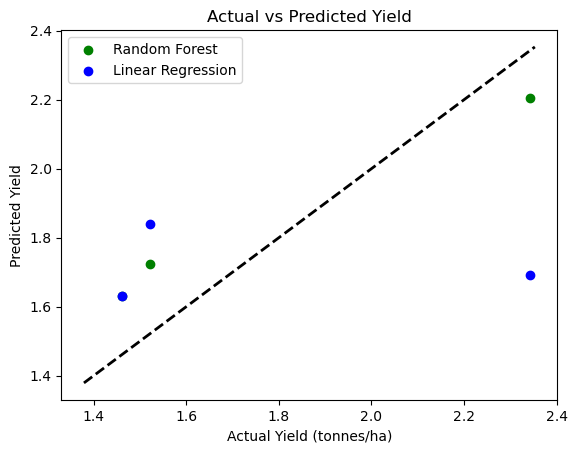

In [7]:
# Evaluate Models
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n  RMSE = {rmse:.2f}\n  R² Score = {r2:.2f}\n")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

# Visualize Predictions vs Actual

plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Yield (tonnes/ha)")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.legend()
plt.show()


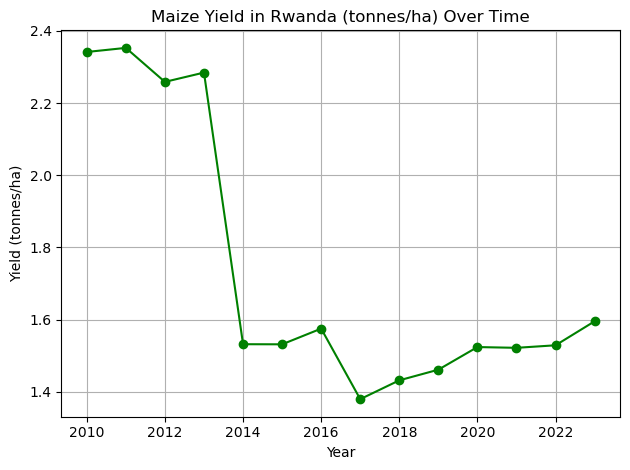

In [8]:
# Plotting the maize yield over time

plt.plot(merged_df['Year'], merged_df['Yield (tonnes/ha)'], marker='o', color='green')
plt.title("Maize Yield in Rwanda (tonnes/ha) Over Time")
plt.xlabel("Year")
plt.ylabel("Yield (tonnes/ha)")
plt.grid(True)
plt.tight_layout()
plt.show()


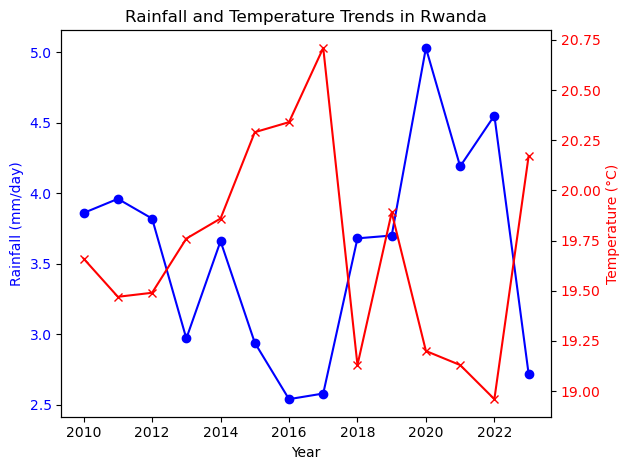

In [9]:
# Plotting Rainfall and Temperature Trends

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("Rainfall (mm/day)", color='blue')
ax1.plot(merged_df['Year'], merged_df['Rainfall (mm/day)'], color='blue', marker='o', label='Rainfall')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)", color='red')
ax2.plot(merged_df['Year'], merged_df['Temperature (°C)'], color='red', marker='x', label='Temperature')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Rainfall and Temperature Trends in Rwanda")
plt.tight_layout()
plt.show()


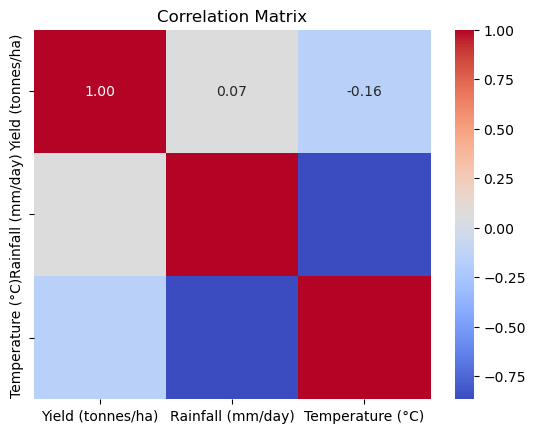

In [10]:
# Correlation Matrix

sns.heatmap(merged_df[['Yield (tonnes/ha)', 'Rainfall (mm/day)', 'Temperature (°C)']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


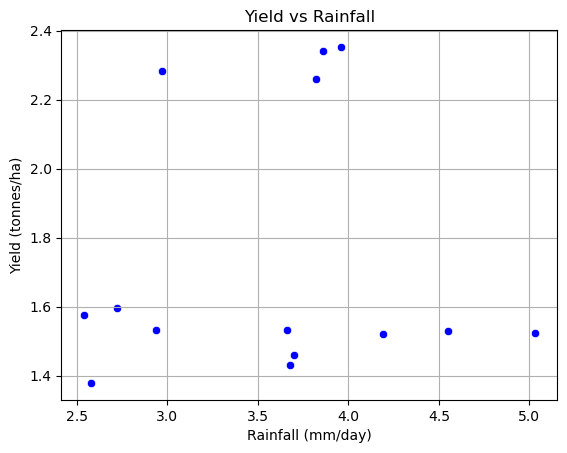

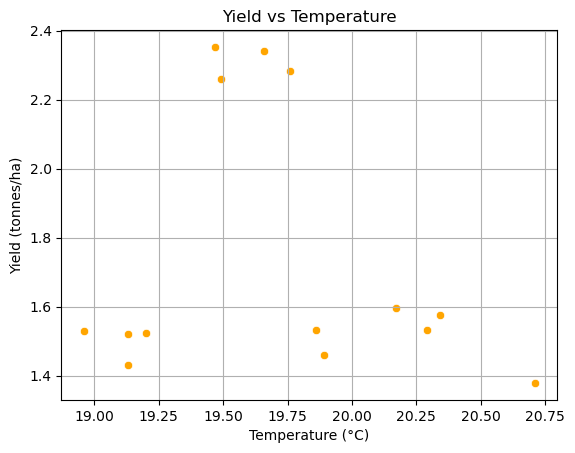

In [11]:
# Scatter Plots for Yield vs Rainfall and Temperature

sns.scatterplot(data=merged_df, x='Rainfall (mm/day)', y='Yield (tonnes/ha)', color='blue')
plt.title("Yield vs Rainfall")
plt.grid(True)
plt.show()

sns.scatterplot(data=merged_df, x='Temperature (°C)', y='Yield (tonnes/ha)', color='orange')
plt.title("Yield vs Temperature")
plt.grid(True)
plt.show()


In [ ]:
# Prediction for Future Years

# Simulated future weather (2026–2030)
forecast_data = pd.DataFrame({
    'Year': [2026, 2027, 2028, 2029, 2030],
    'Rainfall (mm/day)': [3.9, 3.8, 3.7, 4.0, 3.95],
    'Temperature (°C)': [19.5, 19.7, 19.9, 19.6, 19.4]
})

# ✅ Match the original training features
X_future = forecast_data[['Rainfall (mm/day)', 'Temperature (°C)']]

# ✅ Predict using trained model
future_predictions = rf_model.predict(X_future)

# Append predictions
forecast_data['Predicted Yield (tonnes/ha)'] = future_predictions

# Preview results
print(forecast_data)

#Save predictions to CSV
forecast_data.to_csv('future_yield_predictions.csv', index=False)


   Year  Rainfall (mm/day)  Temperature (°C)  Predicted Yield (tonnes/ha)
0  2026               3.90              19.5                     2.217135
1  2027               3.80              19.7                     2.097658
2  2028               3.70              19.9                     1.632115
3  2029               4.00              19.6                     2.217451
4  2030               3.95              19.4                     2.227415
